<a href="https://colab.research.google.com/github/Faheemmalla/IDS-KDD-NSL/blob/main/IDS_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import joblib
import matplotlib.pyplot as plt
import os

In [25]:
import pandas as pd

columns = pd.read_csv("kddcup.names", names=['names'])
data_train = pd.read_csv("KDDTrain+.txt", names=columns["names"])
data_test = pd.read_csv("KDDTest+.txt", names=columns["names"])

d_frame = pd.concat([data_train, data_test], axis=0)

d_frame.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Preprocessing

In [26]:
# Convert categorical labels to binary (0: normal, 1: anomaly)

labels = d_frame['class']
labels = labels.apply(lambda x: 0 if x == 'normal' else 1)
d_frame['label'] = labels

#Feature Engineering

In [27]:
# Group by protocol_type and calculate the number of attacks and total records
attack_counts = d_frame[d_frame['label'] == 1].groupby('protocol_type').size()
total_counts = d_frame.groupby('protocol_type').size()

# Calculate the probability of each protocol type record being an attack
probability_of_attack = (attack_counts / total_counts).fillna(0)


d_frame['protocol_attack_probability'] = d_frame['protocol_type']
d_frame['protocol_attack_probability'] = d_frame['protocol_attack_probability'].map(probability_of_attack)

d_frame.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target,label,protocol_attack_probability
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0.494592
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0.193255
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,0.494592
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0.494592
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0.494592


#Filter Features

In [28]:
col = ['src_bytes','dst_bytes','count','srv_count','num_failed_logins','num_compromised','serror_rate','rerror_rate','num_file_creations','num_shells',]

features = d_frame[col]
features.head()

,src_bytes,dst_bytes,count,srv_count,num_failed_logins,num_compromised,serror_rate,rerror_rate,num_file_creations,num_shells
0,491,0,2,2,0,0,0.0,0.0,0,0
1,146,0,13,1,0,0,0.0,0.0,0,0
2,0,0,123,6,0,0,1.0,0.0,0,0
3,232,8153,5,5,0,0,0.2,0.0,0,0
4,199,420,30,32,0,0,0.0,0.0,0,0


#Split Dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=52)

#Train Model using RF Classifier

In [31]:
param_dist = {'n_estimators': randint(50,100), 'max_depth': randint(1,20)}

rf_classifier = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_classifier, param_distributions = param_dist, n_iter=5, cv=5)

rand_search.fit(X_train, y_train)

best_model = rand_search.best_estimator_

#Prediction and Evaluation

In [32]:
y_pred = rand_search.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1_score:.2f}')

evaluation_results = {
    'accuracy':accuracy ,  # Replace with actual accuracy
    'precision':precision, # Replace with actual precision
    'recall': recall,    # Replace with actual recall
    'f1_score': f1_score   # Replace with actual F1 score
}

Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1-Score: 0.98


In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[22895   146]
 [  792 20723]]


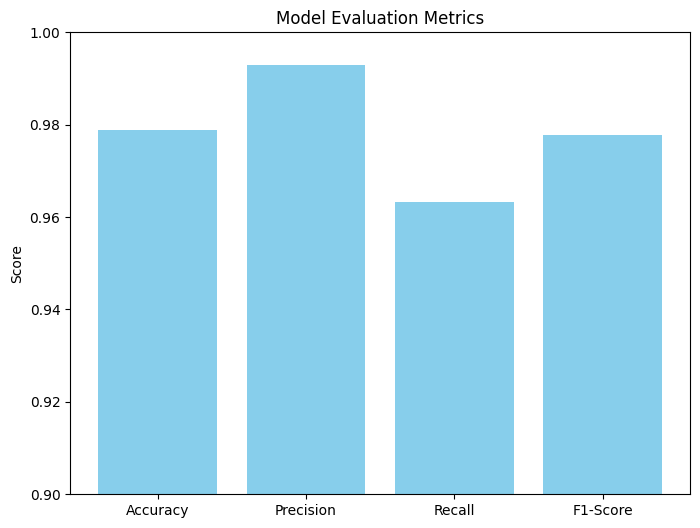

In [34]:
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [evaluation_results['accuracy'],
          evaluation_results['precision'],
          evaluation_results['recall'],
          evaluation_results['f1_score']]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='skyblue')
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0.9, 1)
plt.show()

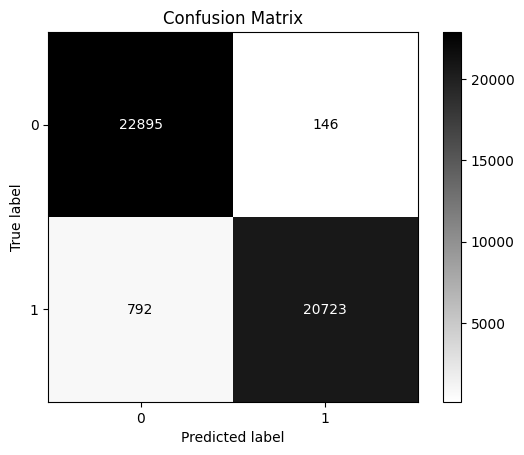

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,cmap='binary')
plt.title('Confusion Matrix')

plt.show()

In [36]:

joblib.dump(best_model, 'IDS_model.pkl')

['IDS_model.pkl']

In [38]:
from google.colab import files
files.download('IDS_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>